# Tomographic mapping notebook  
__Written by Haixing Fang, Jon Wright and James Ball__  
__Date: 21/02/2025__

This notebook will try to reconstruct grain shapes and positions from the grain orientations you found in the first notebook.  
This notebook (and the tomo route in general) works best for low levels of deformation.  
If it doesn't seem to work well, try the point-by-point route instead!

In [1]:
import os

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'

In [2]:
exec(open('/data/id11/nanoscope/install_ImageD11_from_git.py').read())

In [3]:
# this cell is tagged with 'parameters'
# to view the tag, select the cell, then find the settings gear icon (right or left sidebar) and look for Cell Tags

# python environment stuff
PYTHONPATH = setup_ImageD11_from_git( ) # ( os.path.join( os.environ['HOME'],'Code'), 'ImageD11_git' )

# dataset file to import
dset_path = 'si_cube_test/processed/Si_cube/Si_cube_S3DXRD_nt_moves_dty/Si_cube_S3DXRD_nt_moves_dty_dataset.h5'

# which phase to index
phase_str = 'Si'

# peak filtration parameters
cf_strong_frac = 0.993
cf_strong_dstol = 0.005

# If the sinograms are only half-sinograms (we scanned dty across half the sample rather than the full sample), set the below to true:
is_half_scan = False
# If we did halfmask, choose the radius to mask in the centre of the reconstruction (normally hot pixels)
halfmask_radius = 25

# assign peaks to the grains with hkl tolerance peak_assign_tol
peak_assign_tol = 0.05

# We can interactively draw a mask
draw_mask_interactive = True
# or we can threshold with Otsu, or a manual threshold value:
# e.g. manual_threshold = 0.006
manual_threshold = None

# tolerance for building sinograms from assigned peaks
hkltol = 0.25

# We can optionally correct each row of the sinogram by the ring current of that rotation
# This helps remove artifacts in the reconstruction
correct_sinos_with_ring_current = True

first_tmap_cutoff_level = 0.4

# how many iterations for Astra reconstruction?
niter = 500

second_tmap_cutoff_level = 0.05

# Setting path via: 
sys.path.insert(0, /home/esrf/james1997a/Code/ImageD11 )


# Running from: /home/esrf/james1997a/Code/ImageD11/ImageD11/__init__.py


In [4]:
# Parameters
phase_str = "Fe"
cf_strong_frac = 0.9975
cf_strong_dstol = 0.005
is_half_scan = False
halfmask_radius = 25
peak_assign_tol = 0.05
draw_mask_interactive = False
manual_threshold = None
hkltol = 0.25
correct_sinos_with_ring_current = True
first_tmap_cutoff_level = 0.4
niter = 500
second_tmap_cutoff_level = 0.05
PYTHONPATH = "../"
dset_path = "/data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/PROCESSED_DATA/20250221_JADB/tomo_route/FeAu_0p5_tR_nscope/FeAu_0p5_tR_nscope_top_200um/FeAu_0p5_tR_nscope_top_200um_dataset.h5"


In [5]:
import concurrent.futures

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from tqdm.notebook import tqdm

from ImageD11.peakselect import select_ring_peaks_by_intensity
import ImageD11.sinograms.dataset
from ImageD11.sinograms.sinogram import GrainSinogram, read_h5, write_h5, get_2d_peaks_from_4d_peaks
from ImageD11.sinograms.roi_iradon import run_iradon
from ImageD11.sinograms.tensor_map import TensorMap
from ImageD11.sinograms.geometry import sino_shift_and_pad
import ImageD11.nbGui.nb_utils as utils
from ImageD11.nbGui.draw_mask import InteractiveMask, threshold_mask

%matplotlib ipympl

# Load data
## Dataset

In [6]:
ds = ImageD11.sinograms.dataset.load(dset_path)
print(ds)

dataroot = "/data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/RAW_DATA"
analysisroot = "/data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/PROCESSED_DATA/20250221_JADB/tomo_route"
sample = "FeAu_0p5_tR_nscope"
dset = "top_200um"
shape = ( 275, 1448)
# scans 275 from 1.1 to 275.1


## Phases
If the parameter file was a json, we can access the unit cells via `ds.phases.unitcells`

In [7]:
ds.phases = ds.get_phases_from_disk()
ds.phases.unitcells

{'Au': Au | [ 4.005  4.005  4.005 90.    90.    90.   ] | 225,
 'Fe': Fe | [ 2.8694  2.8694  2.8694 90.     90.     90.    ] | 229,
 'CeO2': CeO2 | [ 5.41143  5.41143  5.41143 90.      90.      90.     ] | F}

In [8]:
ucell = ds.phases.unitcells[phase_str]
print(ucell)

Fe | [ 2.8694  2.8694  2.8694 90.     90.     90.    ] | 229


## Peaks

In [9]:
cf_4d = ds.get_cf_4d()
ds.update_colfile_pars(cf_4d)
ucell.makerings(cf_4d.ds.max())
print(f"Read {cf_4d.nrows} 4D peaks")

Loading existing colfile from /data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/PROCESSED_DATA/20250221_JADB/tomo_route/FeAu_0p5_tR_nscope/FeAu_0p5_tR_nscope_top_200um/FeAu_0p5_tR_nscope_top_200um_peaks_4d.h5
Reading your columnfile in hdf format


Read 3304692 4D peaks


## Grains

In [10]:
grains = ds.get_grains_from_disk(phase_str)
grainsinos = [GrainSinogram(g, ds) for g in grains]
utils.get_rgbs_for_grains(grains)
for grain_label, g in enumerate(grains):
    g.gid = grain_label
print(f"{len(grains)} grains imported")

Adding reference unitcells from self.phases


60 grains imported


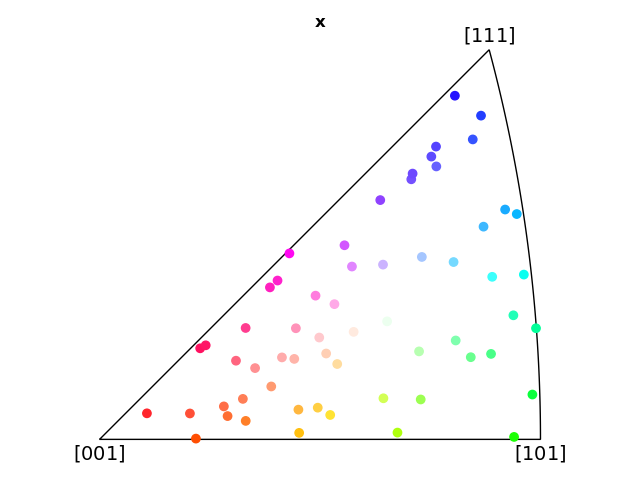

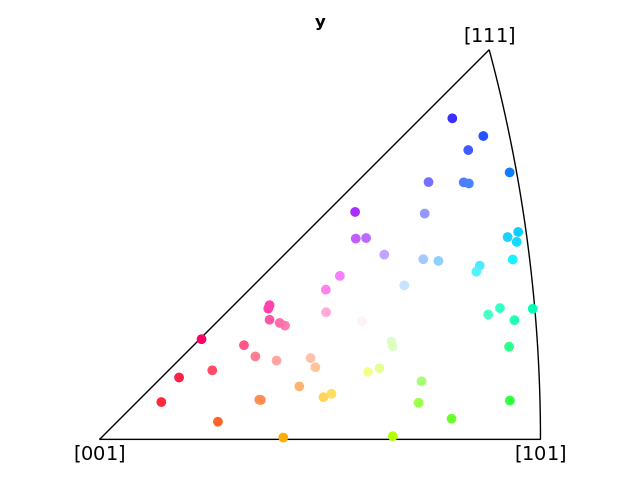

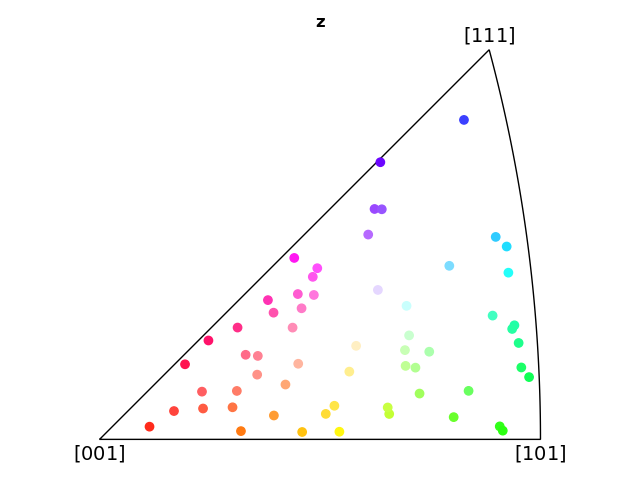

In [11]:
utils.plot_all_ipfs(grains)

# Filtration
Here we are filtering our peaks (`cf_4d`) to select only the strongest ones.  
This time, we don't clip via `dsmax`, because we need the higher-angle projections for complete sinograms.  
We first filter the peaks in $d^{*}$ to keep only those close to the predicted peaks from the unit cell.  
We then sort our peaks by intensity, and take a certain intensity-weighted fraction of them.  
`dstol`: The tolerance in $d^{*}$ between a peak and a predicted reflection.  
`frac`: The intensity fraction: `frac=0.9` keeps 90% of the peak intensity. We recommend that you choose a value close to the 'elbow' of the plot.

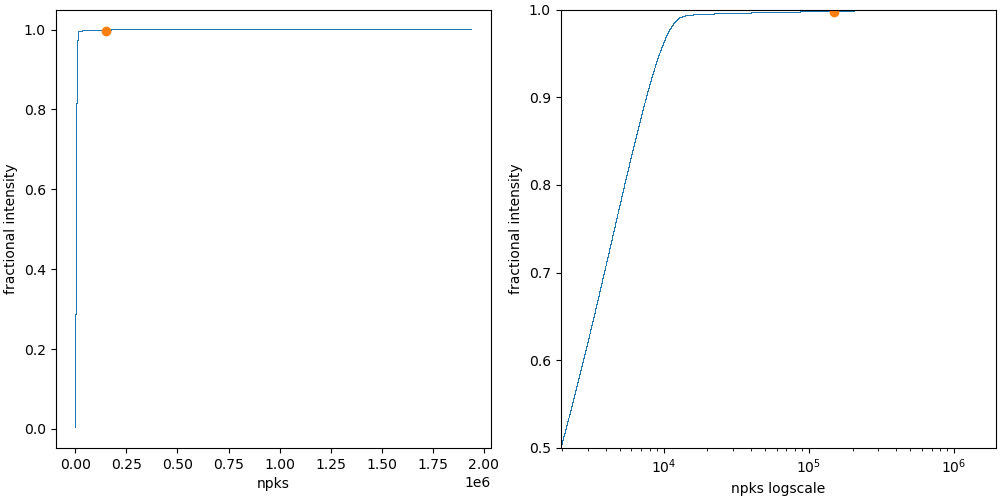

Filtered 148470 peaks from 3304692


In [12]:
cf_strong = select_ring_peaks_by_intensity(cf_4d, frac=cf_strong_frac, dstol=cf_strong_dstol, dsmax=cf_4d.ds.max(), ucell=ucell, doplot=0.5)

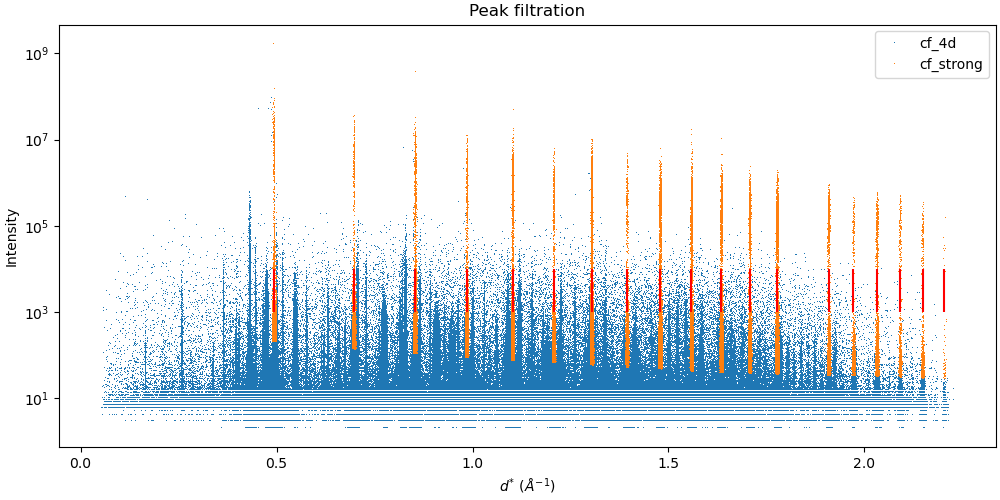

In [13]:
skip = 1  # we can skip peaks to speed up plotting if needed
fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)
ax.plot(cf_4d.ds[::skip], cf_4d.sum_intensity[::skip],',', label='cf_4d')
ax.plot(cf_strong.ds[::skip], cf_strong.sum_intensity[::skip],',', label='cf_strong')
ax.vlines(ucell.ringds, 1e3, 1e4, color='red')
ax.set(xlabel=r'$d^{*}~(\AA^{-1})$', ylabel='Intensity', yscale='log', title='Peak filtration')
ax.legend()
plt.show()

# Peak assignment

In [14]:
utils.assign_peaks_to_grains(grains, cf_strong, peak_assign_tol)
for grain_label, g in enumerate(grains):
    g.gid = grain_label
    g.npks_4d = np.sum(cf_strong.grain_id == grain_label)

Scoring and assigning 60 grains


  0%|          | 0/60 [00:00<?, ?it/s]

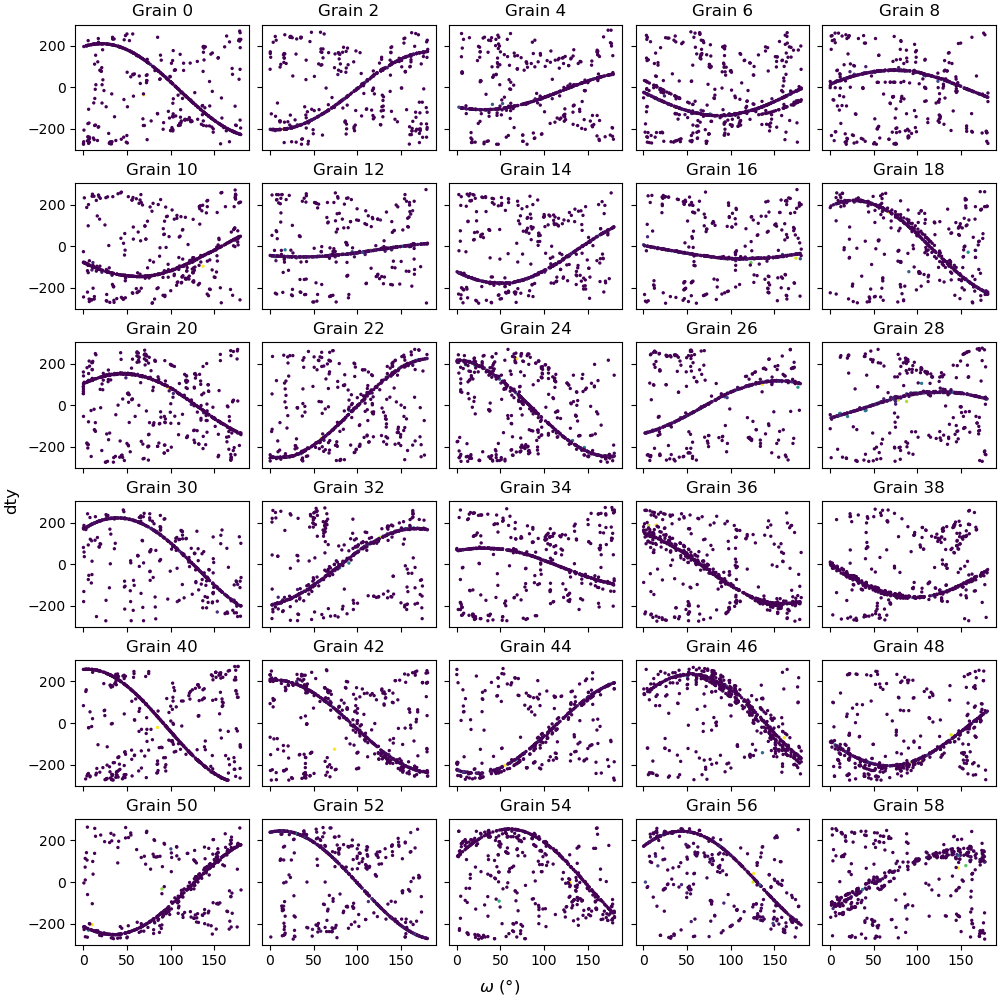

In [15]:
utils.plot_grain_sinograms(grains, cf_strong, min(len(grains), 25))

# Grain position refinement

In [16]:
for grain_label, gs in enumerate(grainsinos):
    gs.update_lab_position_from_peaks(cf_strong, grain_label)

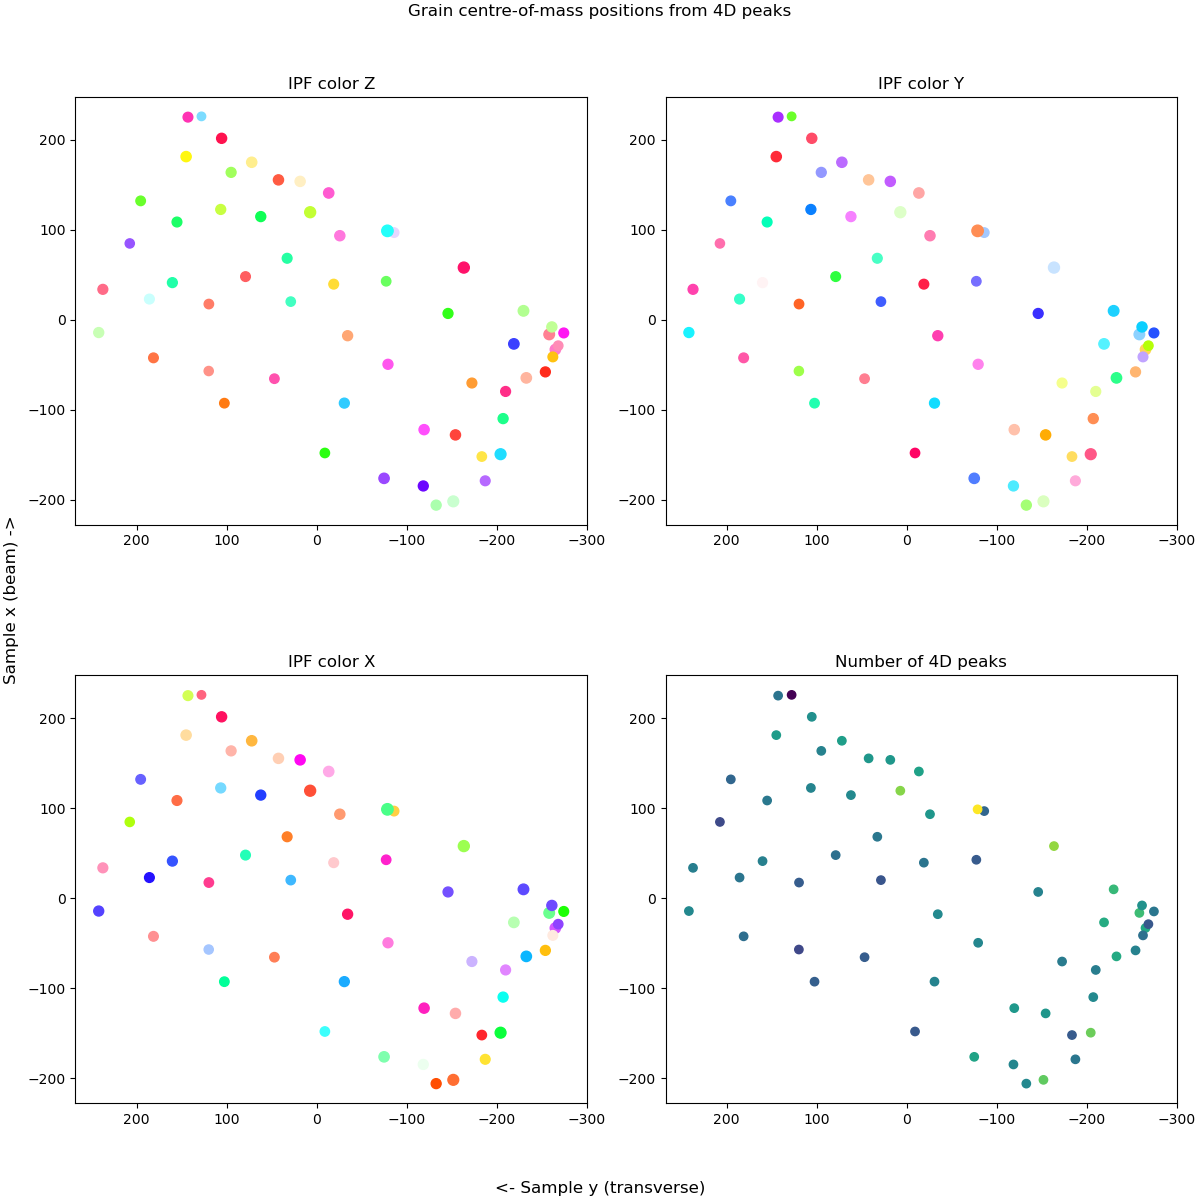

In [17]:
# plt.style.use('dark_background')
fig, ax = plt.subplots(2,2, figsize=(12,12), layout='constrained')
a = ax.ravel()
x = [g.translation[0] for g in grains]
y = [g.translation[1] for g in grains]
s = [g.npks_4d/10 for g in grains]
a[0].scatter(y, x, c=[g.rgb_z for g in grains], s=s)
a[0].set(title='IPF color Z',  aspect='equal')
a[1].scatter(y, x, c=[g.rgb_y for g in grains], s=s)
a[1].set(title='IPF color Y', aspect='equal')
a[2].scatter(y, x, c=[g.rgb_x for g in grains], s=s)
a[2].set(title='IPF color X',  aspect='equal')
a[3].scatter(y, x, c=s)
a[3].set(title='Number of 4D peaks', aspect='equal')
fig.supxlabel("<- Sample y (transverse)")
fig.supylabel("Sample x (beam) ->")
fig.suptitle("Grain centre-of-mass positions from 4D peaks")
for a in ax.ravel():
    a.invert_xaxis()
plt.show()

# $y_0$ refinement
We need to determine what the value of `dtymotor` is where the rotation axis intercepts the beam.  
This should be close to zero for the NSCOPE station, and somewhere around `14 mm` for the TDXRD station.

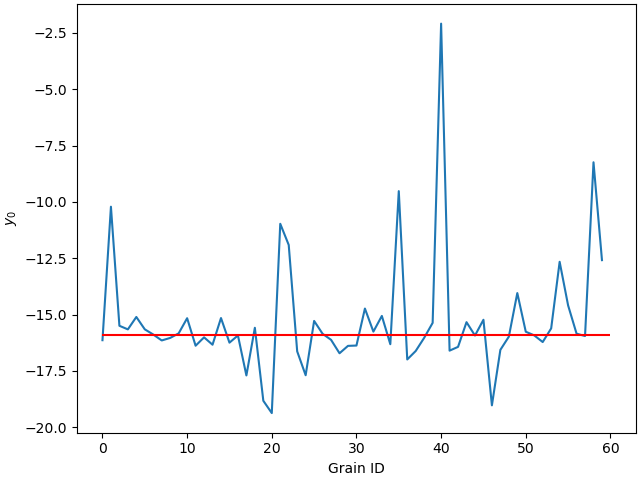

y0 is -15.901900446683953
shift is 8.450946676239795
pad is 18


In [18]:
sample_y0s = [gs.recon_y0 for gs in grainsinos]
y0 = np.median(sample_y0s)
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(sample_y0s)
ax.hlines(y0, 0, len(grainsinos), color='red')
ax.set(xlabel='Grain ID', ylabel=r'$y_0$')
plt.show()
print('y0 is', y0)
if is_half_scan:
    ds.correct_bins_for_half_scan(y0=y0)
# try to automatically determine the sinogram shift and the padding from the y0 values
shift, pad = sino_shift_and_pad(y0, len(ds.ybincens), min(ds.ybincens), ds.ystep)
print('shift is', shift)
print('pad is', pad)
# update the grainsinogram parameters accordingly:
for gs in grainsinos:
    gs.update_recon_parameters(y0=y0, shift=shift, pad=pad)

# Whole-sample mask

Our next task is to determine a reconstruction mask for the entire sample.

This should adequately differentiate between sample and air.

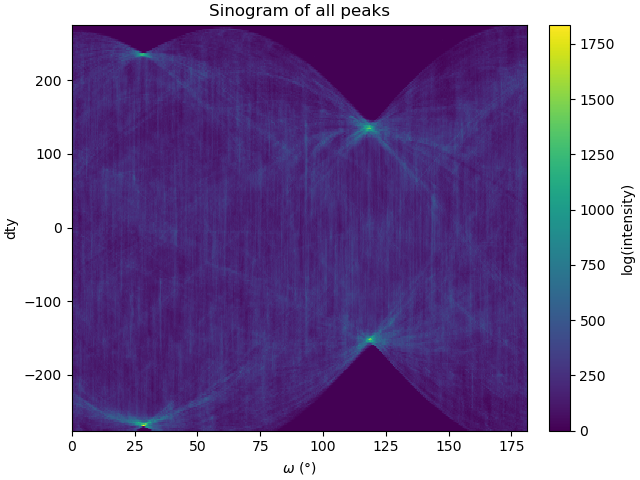

In [19]:
fig, ax = plt.subplots(layout='constrained')
whole_sample_sino, om_edges, dty_edges = ds.sinohist(np.log(ds.pk2d['sum_intensity']), ds.pk2d['omega'], ds.pk2d['dty'], return_edges=True)
whole_sample_sino = whole_sample_sino.T
pcm = ax.pcolormesh(om_edges, dty_edges, whole_sample_sino)
ax.set(xlabel=r'$\omega~(\degree)$', ylabel='dty', title='Sinogram of all peaks')
cax = fig.colorbar(pcm, ax=ax, label='log(intensity)')
plt.show()

In [20]:
nthreads = len(os.sched_getaffinity(os.getpid()))
whole_sample_recon = run_iradon(whole_sample_sino, ds.obincens, pad, shift, workers=nthreads, apply_halfmask=is_half_scan, mask_central_zingers=is_half_scan)

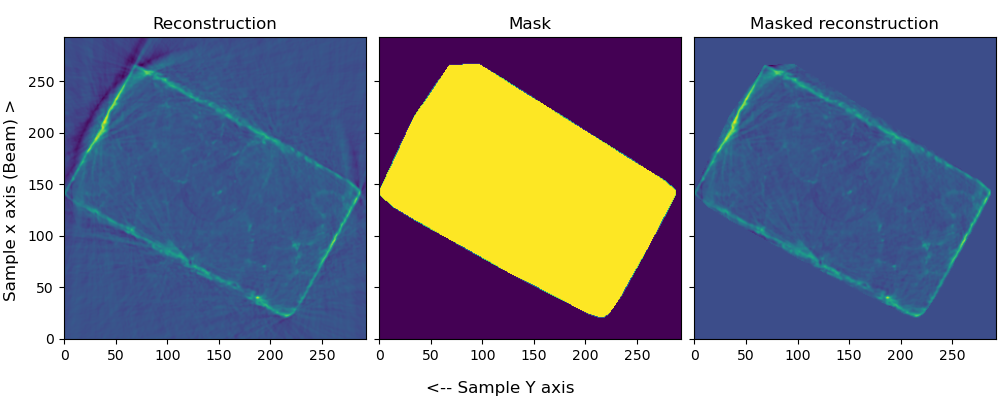

In [21]:
# Now we generate a whole-sample mask for the image
if draw_mask_interactive:
    masker = InteractiveMask(whole_sample_recon)
else:
    whole_sample_mask = threshold_mask(whole_sample_recon, manual_threshold=manual_threshold, doplot=True)

In [22]:
if draw_mask_interactive:
    whole_sample_mask = masker.get_mask(doplot=True)

# Grain sinogram generation

In [23]:
gord, inds = get_2d_peaks_from_4d_peaks(ds.pk2d, cf_strong)
for grain_label, gs in enumerate(tqdm(grainsinos)):
    gs.prepare_peaks_from_4d(cf_strong, gord, inds, grain_label, hkltol)

  0%|          | 0/60 [00:00<?, ?it/s]

In [24]:
for gs in tqdm(grainsinos):
    gs.build_sinogram()

  0%|          | 0/60 [00:00<?, ?it/s]

In [25]:
# optionally correct the halfmask:
if is_half_scan:
    for gs in grainsinos:
        gs.correct_halfmask()

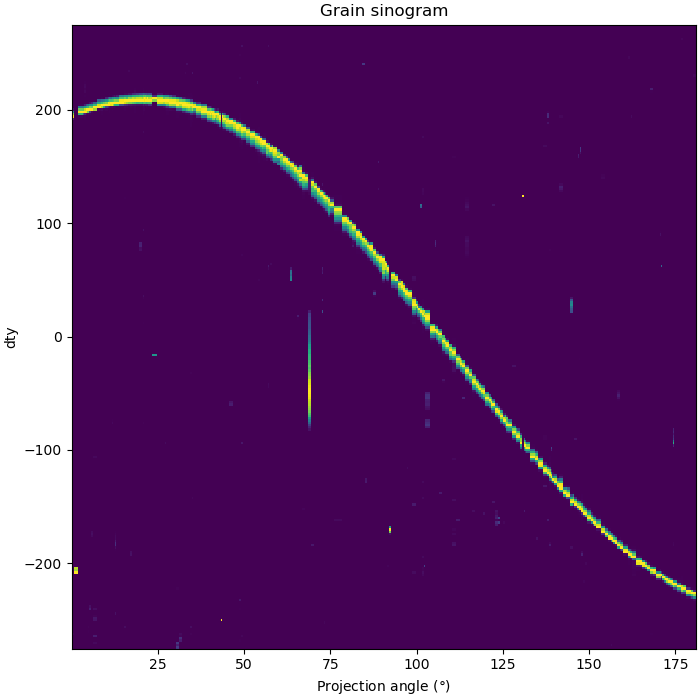

In [26]:
gs = grainsinos[0]
fig, ax = plt.subplots(figsize=(7, 7), layout='constrained')
ax.pcolormesh(gs.sinoangles, ds.ybincens, gs.ssino)
ax.set(xlabel=r'Projection angle ($\degree$)', ylabel='dty', title='Grain sinogram')
plt.show()

In [27]:
# We can optionally correct each row of the sinogram by the ring current of that rotation
# This helps remove artifacts in the reconstruction
if correct_sinos_with_ring_current:
    ds.get_ring_current_per_scan()
    for gs in grainsinos:
        gs.correct_ring_current(is_half_scan=is_half_scan)

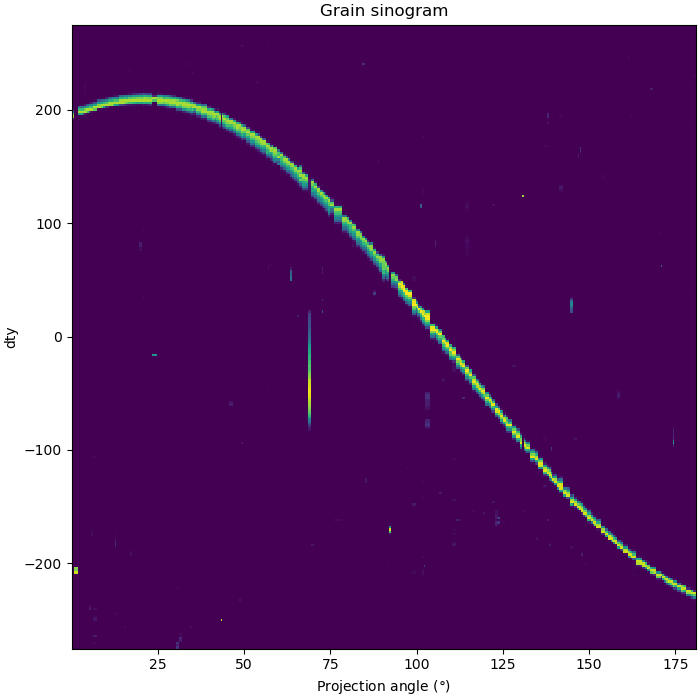

In [28]:
gs = grainsinos[0]
fig, ax = plt.subplots(figsize=(7, 7), layout='constrained')
ax.pcolormesh(gs.sinoangles, ds.ybincens, gs.ssino)
ax.set(xlabel=r'Projection angle ($\degree$)', ylabel='dty', title='Grain sinogram')
plt.show()

# Grain shape reconstruction
## iradon
### First grain as example

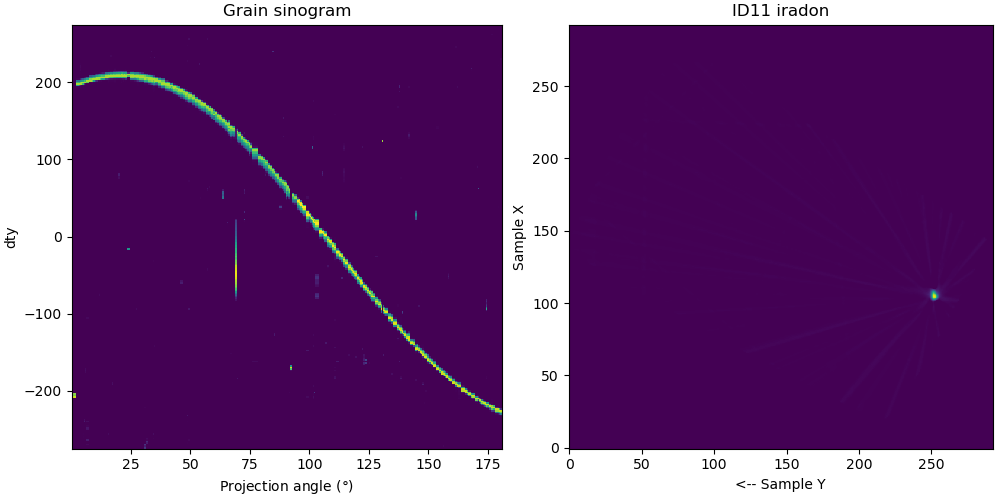

In [29]:
gs.update_recon_parameters(pad=pad, shift=shift, mask=whole_sample_mask, y0=y0)
gs.recon()
if is_half_scan:
    gs.mask_central_zingers("iradon", radius=halfmask_radius)
fig, axs = plt.subplots(1,2, figsize=(10,5), layout="constrained")
axs[0].pcolormesh(gs.sinoangles, ds.ybincens, gs.ssino)
axs[0].set(xlabel=r'Projection angle ($\degree$)', ylabel='dty', title='Grain sinogram')
axs[1].imshow(gs.recons["iradon"], vmin=0, origin="lower")
axs[1].set(title="ID11 iradon", xlabel="<-- Sample Y", ylabel="Sample X")
plt.show()

In [30]:
for gs in grainsinos:
    gs.update_recon_parameters(pad=pad, shift=shift, mask=whole_sample_mask, y0=y0)

### Reconstruct all grains

In [31]:
with concurrent.futures.ThreadPoolExecutor(max_workers= max(1,nthreads-1)) as pool:
    for i in tqdm(pool.map(GrainSinogram.recon, grainsinos), total=len(grainsinos)):
        pass
if is_half_scan:
    for gs in grainsinos:
        gs.mask_central_zingers("iradon", radius=halfmask_radius)

  0%|          | 0/60 [00:00<?, ?it/s]

### View outputs

interactive(children=(IntSlider(value=0, description='Grain:', max=59), Output()), _dom_classes=('widget-inter…

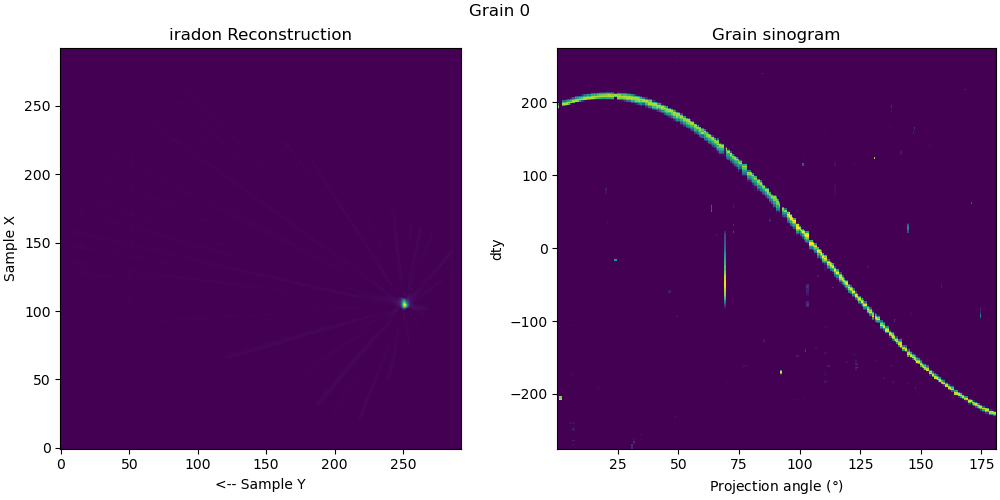

In [32]:
def update_frame(i):
    rec.set_array(grainsinos[i].recons["iradon"])
    sin = a[1].pcolormesh(grainsinos[i].sinoangles, ds.ybincens, grainsinos[i].ssino)
    fig.suptitle("Grain " + str(i))
    fig.canvas.draw()
frame_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(grains) - 1,
    step=1,
    description='Grain:'
)
fig, a = plt.subplots(1,2,figsize=(10,5), constrained_layout=True)
rec = a[0].imshow(grainsinos[0].recons["iradon"], vmin=0, origin="lower")
sin = a[1].pcolormesh(grainsinos[0].sinoangles, ds.ybincens, grainsinos[0].ssino)
a[0].set(xlabel="<-- Sample Y", ylabel="Sample X", title="iradon Reconstruction")
a[1].set(xlabel=r'Projection angle ($\degree$)', ylabel='dty', title='Grain sinogram')
widgets.interact(update_frame, i=frame_slider)
plt.show()

### Assemble TensorMap

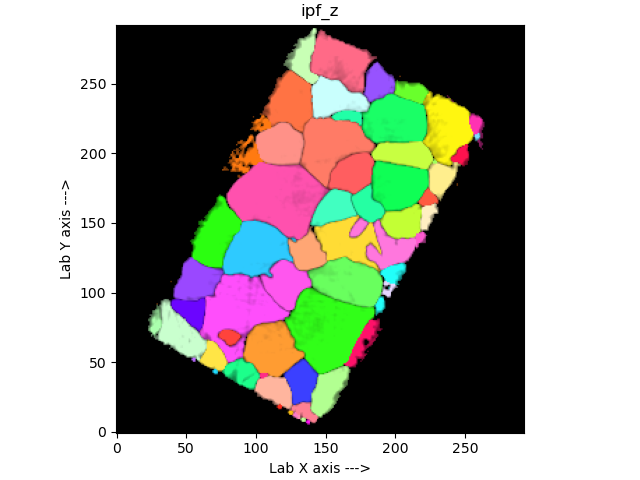

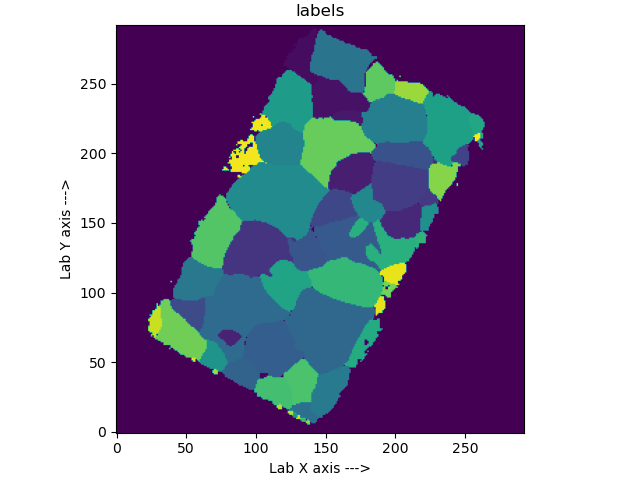

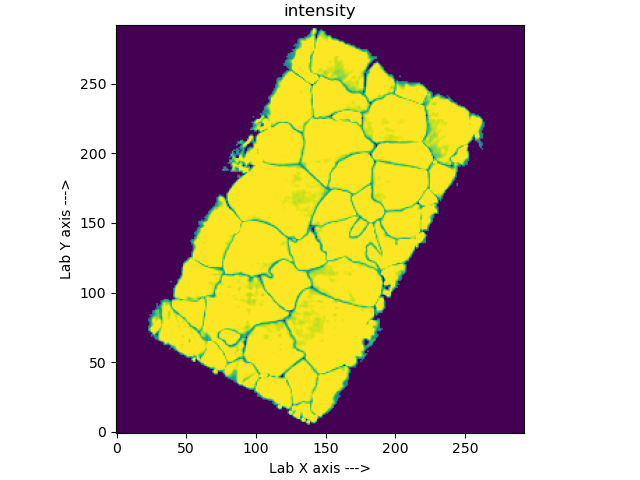

In [33]:
tensor_map = TensorMap.from_grainsinos(grainsinos, cutoff_level=first_tmap_cutoff_level)
tensor_map.plot("ipf_z")
tensor_map.plot("labels")
tensor_map.plot("intensity")

## ASTRA
We can clean up these reconstructions using an MLEM iterative recon.  
We will carry this out using ASTRA on the GPU on the SLURM cluster.  
The ASTRA EM_CUDA method will be used.

In [34]:
for gs in grainsinos:
    gs.update_recon_parameters(pad=pad, shift=shift, mask=whole_sample_mask, niter=niter, y0=y0)
write_h5(ds.grainsfile, grainsinos, overwrite_grains=True, group_name=phase_str)

In [35]:
bash_script_path = utils.prepare_astra_bash(ds, ds.grainsfile, PYTHONPATH, group_name=phase_str)
utils.slurm_submit_and_wait(bash_script_path, 10)

Submitted batch job 21510693
21510693
Slurm job not finished! Waiting 10 seconds...


Slurm job not finished! Waiting 10 seconds...


Slurm job finished!


In [36]:
grainsinos = read_h5(ds.grainsfile, ds, group_name=phase_str)
for gs, g in zip(grainsinos, grains):
    gs.grain = g
    gs.ds = ds

### View outputs

interactive(children=(IntSlider(value=0, description='Grain:', max=59), Output()), _dom_classes=('widget-inter…

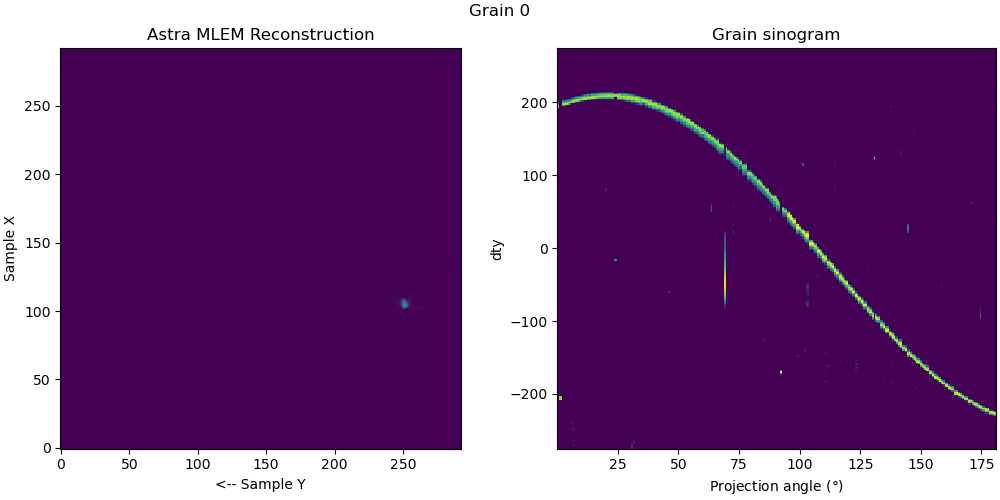

In [37]:
def update_frame(i):
    rec.set_array(grainsinos[i].recons["iradon"])
    sin = a[1].pcolormesh(grainsinos[i].sinoangles, ds.ybincens, grainsinos[i].ssino)
    fig.suptitle("Grain " + str(i))
    fig.canvas.draw()
frame_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(grains) - 1,
    step=1,
    description='Grain:'
)
fig, a = plt.subplots(1,2,figsize=(10,5), constrained_layout=True)
rec = a[0].imshow(grainsinos[0].recons["astra"], vmin=0, origin="lower")
sin = a[1].pcolormesh(grainsinos[0].sinoangles, ds.ybincens, grainsinos[0].ssino)
a[0].set(xlabel="<-- Sample Y", ylabel="Sample X", title="Astra MLEM Reconstruction")
a[1].set(xlabel=r'Projection angle ($\degree$)', ylabel='dty', title='Grain sinogram')
widgets.interact(update_frame, i=frame_slider)
plt.show()

### Assemble TensorMap

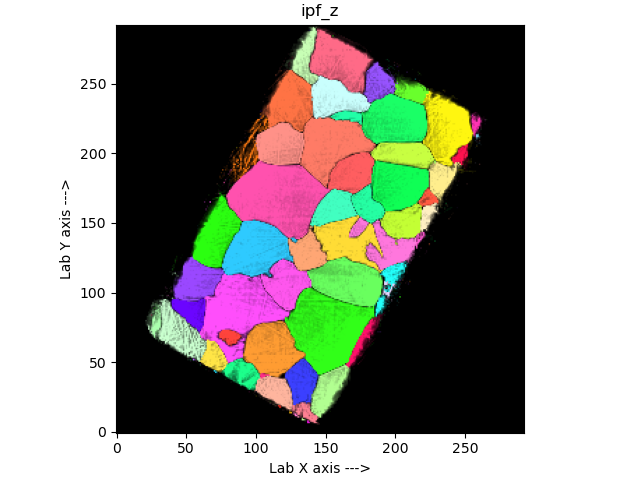

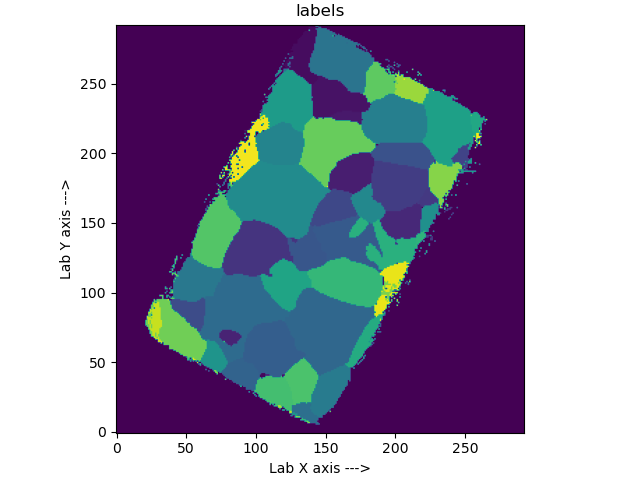

/home/esrf/james1997a/Code/ImageD11/ImageD11/sinograms/tensor_map.py:620: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(layout='constrained')


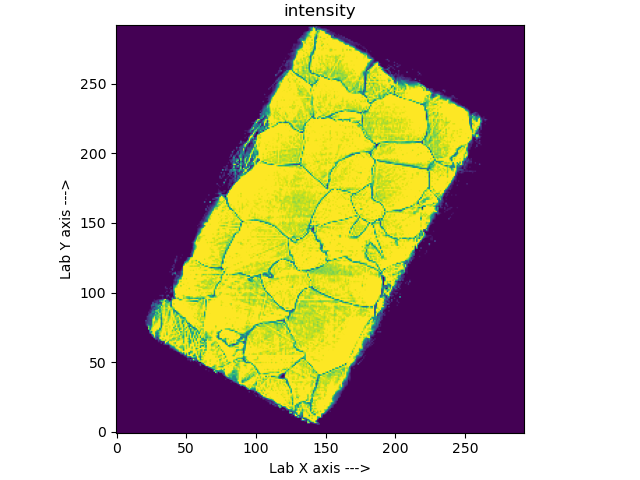

In [38]:
tensor_map_astra = TensorMap.from_grainsinos(grainsinos, cutoff_level=second_tmap_cutoff_level, method="astra")
tensor_map_astra.plot("ipf_z")
tensor_map_astra.plot("labels")
tensor_map_astra.plot("intensity")

# Export
## Grains

In [39]:
write_h5(ds.grainsfile, grainsinos, overwrite_grains=True, group_name=phase_str)

## TensorMap

In [40]:
tensor_map_astra.to_h5(ds.grainsfile, h5group='TensorMap_' + phase_str)

## XDMF

In [41]:
tensor_map_astra.to_paraview(ds.grainsfile, h5group='TensorMap_' + phase_str)

In [42]:
ds.save()